<a href="https://colab.research.google.com/github/caiogasparine/SCS_3253_061-Machine-Learning/blob/main/Toronto_Police_Major_Crime_Indicators_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Source of Data: Major Crime Indicators (MCI) Historical**

This dataset includes all Major Crime Indicators (MCI) occurrences by reported date and related offences from 2014 to June 30, 2022.

https://data.torontopolice.on.ca/pages/major-crime-indicators


# 1 - Big Picture / Frame the problem 
University of Toronto
SCS 3253-061 - Machine Learning
Saeid Abolfazli

**Group Members:**
*   Caio Gasparine
*   Fabio Queiroz
*   Olivier Sangam
*   Illidan Yuan

# 2 - Get the data / Develop the pipeline

Data profiling was done to ensure data quality and integrity. Contents of each field were analyzed for any anomalies and Null values. None we found.

In [2]:
### Loading the main used libraries
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from pandas.plotting import scatter_matrix
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
### Change the code here, depending on your dataset location
### data = pd.read_csv('Major_Crime_Indicators.csv', header=0)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major_Crime_Indicators.csv', header=0)

In [4]:
data.shape

(301233, 30)

In [5]:
data.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'Longitude', 'Latitude',
       'ObjectId'],
      dtype='object')

# 3- Explore and visualize the data to gain insights


In [6]:
data.head(5)

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    301233 non-null  float64
 1   Y                    301233 non-null  float64
 2   Index_               301233 non-null  int64  
 3   event_unique_id      301233 non-null  object 
 4   Division             301233 non-null  object 
 5   occurrencedate       301233 non-null  object 
 6   reporteddate         301233 non-null  object 
 7   location_type        301233 non-null  object 
 8   premises_type        301233 non-null  object 
 9   ucr_code             301233 non-null  int64  
 10  ucr_ext              301233 non-null  int64  
 11  offence              301233 non-null  object 
 12  reportedyear         301233 non-null  int64  
 13  reportedmonth        301233 non-null  object 
 14  reportedday          301233 non-null  int64  
 15  reporteddayofyear

In [8]:
data['mci_category'].value_counts()

Assault            161833
Break and Enter     59440
Auto Theft          40794
Robbery             29230
Theft Over           9936
Name: mci_category, dtype: int64

In [9]:
data['location_type'].value_counts()

Apartment (Rooming House, Condo)                                          72061
Single Home, House (Attach Garage, Cottage, Mobile)                       54076
Streets, Roads, Highways (Bicycle Path, Private Road)                     47619
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    34774
Parking Lots (Apt., Commercial Or Non-Commercial)                         25322
Bar / Restaurant                                                          12031
Open Areas (Lakes, Parks, Rivers)                                          6278
Schools During Supervised Activity                                         4567
Convenience Stores                                                         3851
Ttc Subway Station                                                         3648
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          3454
Private Property Structure (Pool, Shed, Detached Garage)                   2743
Hospital / Institutions / Medical Facili

In [24]:
data['ucr_code'].value_counts()

1430    110901
2120     59416
2135     40794
1420     34218
1610     29229
2130      7018
1460      5282
1480      3486
1450      3471
1410      2502
2132      2423
1457      1089
1461       559
2133       495
1455       180
1470       106
1462        23
1440        14
2125        13
2121        11
1475         2
1611         1
Name: ucr_code, dtype: int64

In [26]:
data['premises_type'].value_counts()

Outside        80079
Apartment      72061
Commercial     60860
House          54076
Other          17788
Transit         8603
Educational     7766
Name: premises_type, dtype: int64

In [27]:
data['offence'].value_counts()

Assault                           110528
B&E                                50182
Theft Of Motor Vehicle             40794
Assault With Weapon                27191
Robbery - Mugging                   8393
B&E W'Intent                        7311
Assault Bodily Harm                 7027
Theft Over                          5532
Assault Peace Officer               5174
Robbery - Other                     4857
Robbery With Weapon                 4798
Robbery - Business                  4343
Assault - Resist/ Prevent Seiz      3018
Aggravated Assault                  2483
Theft From Motor Vehicle Over       2423
Robbery - Swarming                  2289
Discharge Firearm With Intent       2003
Unlawfully In Dwelling-House        1821
Discharge Firearm - Recklessly      1441
Theft From Mail / Bag / Key         1197
Robbery - Home Invasion             1132
Pointing A Firearm                  1089
Robbery - Purse Snatch              1039
Robbery - Financial Institute        891
Robbery - Vehicl

In [10]:
data.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,3.012330e+05,3.012330e+05,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301133.000000,301133.000000,301133.000000,301233.000000,301233.000000,301233.000000,301233.000000
mean,-8.724562e+06,5.350375e+06,150617.000000,1702.422928,146.565585,2017.876713,15.736659,180.765756,12.808786,2017.822852,15.456476,180.544766,12.601591,-78.374071,43.143874,150617.000000
std,9.966746e+05,6.112283e+05,86958.621157,326.260102,51.988967,2.436940,8.766766,103.717225,6.502562,2.475716,8.914754,104.141362,7.243753,8.953280,4.928613,86958.621157
min,-8.910331e+06,0.000000e+00,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846681e+06,5.412946e+06,75309.000000,1430.000000,100.000000,2016.000000,8.000000,92.000000,8.000000,2016.000000,8.000000,92.000000,7.000000,-79.471086,43.659806,75309.000000
50%,-8.838015e+06,5.419000e+06,150617.000000,1450.000000,100.000000,2018.000000,16.000000,178.000000,13.000000,2018.000000,15.000000,178.000000,14.000000,-79.393238,43.699132,150617.000000
75%,-8.829868e+06,5.426986e+06,225925.000000,2120.000000,200.000000,2020.000000,23.000000,270.000000,18.000000,2020.000000,23.000000,270.000000,19.000000,-79.320056,43.750978,225925.000000
max,0.000000e+00,5.517228e+06,301233.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2022.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301233.000000


In [11]:
# Check if any column has missing values ("False" = not missing - "True" = missing)
data.isnull().any()

X                      False
Y                      False
Index_                 False
event_unique_id        False
Division               False
occurrencedate         False
reporteddate           False
location_type          False
premises_type          False
ucr_code               False
ucr_ext                False
offence                False
reportedyear           False
reportedmonth          False
reportedday            False
reporteddayofyear      False
reporteddayofweek      False
reportedhour           False
occurrenceyear          True
occurrencemonth         True
occurrenceday           True
occurrencedayofyear     True
occurrencedayofweek     True
occurrencehour         False
mci_category           False
Hood_ID                False
Neighbourhood          False
Longitude              False
Latitude               False
ObjectId               False
dtype: bool

In [12]:
data[['mci_category','offence','ucr_ext']]

,mci_category,offence,ucr_ext
0,Assault,Assault,100
1,Break and Enter,B&E,200
2,Assault,Assault,100
3,Theft Over,Theft Over,210
4,Robbery,Robbery - Business,210
...,...,...,...
301228,Auto Theft,Theft Of Motor Vehicle,210
301229,Auto Theft,Theft Of Motor Vehicle,210
301230,Auto Theft,Theft Of Motor Vehicle,210
301231,Auto Theft,Theft Of Motor Vehicle,210


In [13]:
data["mci_category"].value_counts()

Assault            161833
Break and Enter     59440
Auto Theft          40794
Robbery             29230
Theft Over           9936
Name: mci_category, dtype: int64

In [14]:
### Exploring the data to gain insigths
### Latitue and Longitude int(values) => 43 / -79 // a couple of ZEROS

data[['Latitude','Longitude']]

,Latitude,Longitude
0,43.766371,-79.504475
1,43.814861,-79.217083
2,43.589085,-79.534957
3,43.703212,-79.346588
4,43.645247,-79.531916
...,...,...
301228,43.790363,-79.455098
301229,43.775740,-79.234954
301230,43.765801,-79.281037
301231,0.000000,0.000000


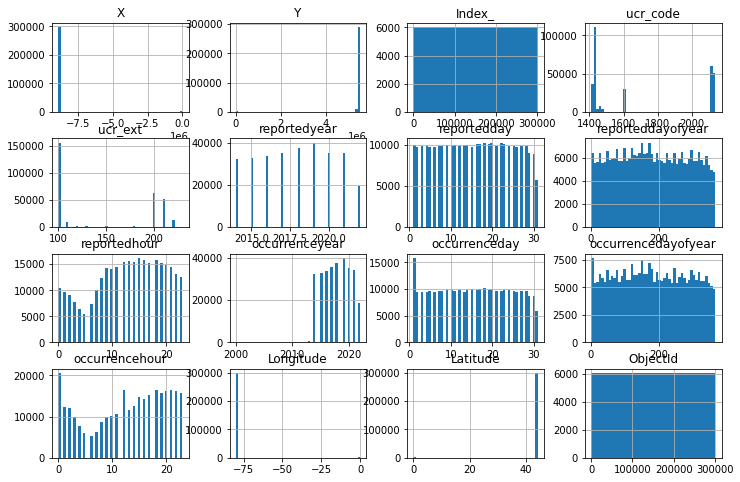

In [15]:
### Exploring the data to gain insigths
### Histogram for each numerical atribute

import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(12,8))
plt.show()

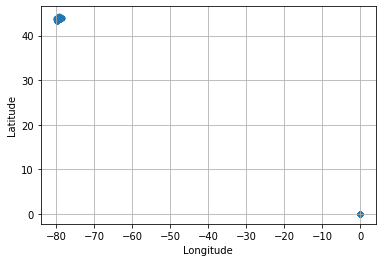

In [16]:
### Exploring the data to gain insigths
### Visualizing Goegraphical Data

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [17]:
### Exploring the data to gain insigths
### Looking for correlations

corr_matrix = data.corr()
corr_matrix ["ucr_code"].sort_values(ascending=False)

ucr_code               1.000000
ucr_ext                0.920490
occurrenceyear         0.043597
Index_                 0.035648
ObjectId               0.035639
reportedyear           0.034324
Y                      0.025611
Latitude               0.025505
occurrenceday          0.011813
occurrencedayofyear    0.008028
reporteddayofyear      0.002388
reportedday           -0.000665
Longitude             -0.025991
X                     -0.025991
occurrencehour        -0.041091
reportedhour          -0.077251
Name: ucr_code, dtype: float64

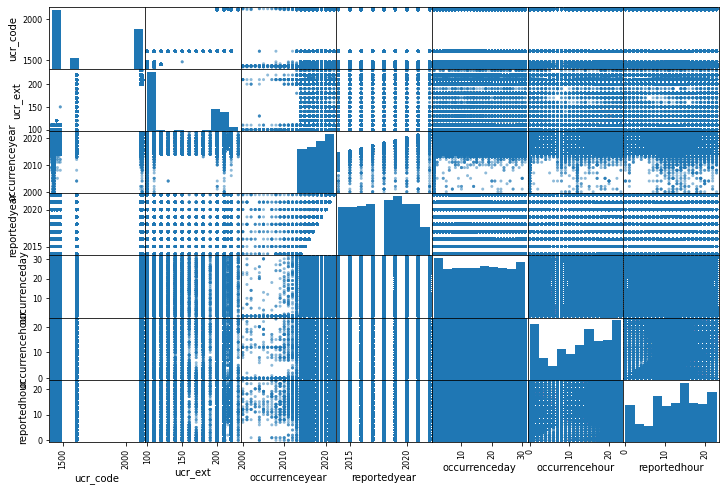

In [18]:
### Exploring the data to gain insigths
### Looking for correlations - using pandas Scatter Matrix
### Scatter Matrix plots every numerical atribute against every other attribite, plus a histogram of each numerical atribute's value on the main diagonal top left to bottom rigth 

from pandas.plotting import scatter_matrix
attributes = ["ucr_code", "ucr_ext", "occurrenceyear", "reportedyear", "occurrenceday", "occurrencehour", "reportedhour"]
scatter_matrix(data[attributes], figsize=(12,8))
plt.show()

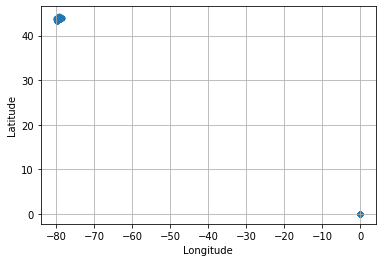

In [19]:
### Exploring the data to gain insigths
### Experiments - Attribute combinations (66)

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [20]:
### Clean the data (68)
### Get rid of the instance / Get rid of the whole attribute / Set the missing values to some value (zero, median, mean, etc.)
### Panda's dataframe > dropna(), drop(), fillna() + Scikit-Learn SimpleImputer
### Solving the issue with Latitude and Longitude - ZERO VALUES

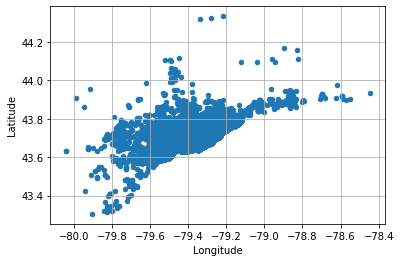

In [21]:
### Replace ZERO values for NaN = Not a number
###
###data.replace(0, np.nan, inplace=True) ### To replace all the columns

cols = ["Latitude","Longitude"]
data[cols] = data[cols].replace(['0', 0], np.nan)

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

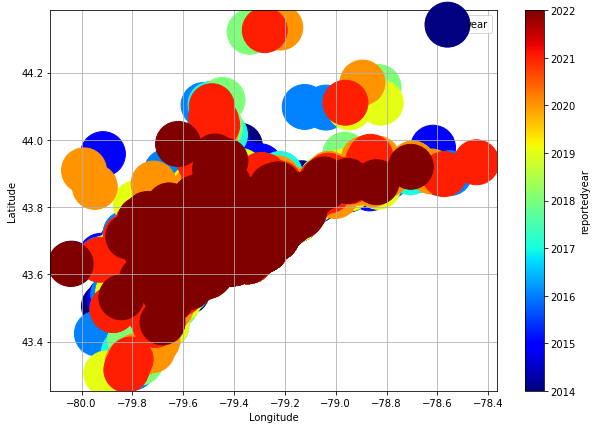

In [22]:
### Replace ZERO values for NaN = Not a number
### I am missing a value variable, so for testing purposes I used reportedyear field LOL!!!
###

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=data["reportedyear"], label = "year",
          c="reportedyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,7))
plt.show()

In [23]:
### Adding a new attribute qtd of days since reported first time - using current date
### date.today() / datetime.now()
### time.struct_time((d.year, d.month, d.day, 0, 0, 0, d.weekday(), yday, -1))
### https://docs.python.org/3/library/datetime.html
### class datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)

from datetime import date
from datetime import datetime
today_date_iso = (datetime.today())
data['reporteddate'] = pd.to_datetime(data['reporteddate'])
data['days_since_reported'] = today_date_iso - datetime(data['reporteddate'], tzinfo=None).isoformat() 

#(pd.to_datetime(data['reporteddate']))
#data['reporteddate'] = datetime(data['reporteddate']).isoformat()
#data["days_since_reported"] = (datetime(2023, 2, 23, tzinfo=None).isoformat()) - (datetime(data['reporteddate'], tzinfo=None).isoformat())

#today = today.replace(tzinfo=None)


TypeError: ignored

In [29]:
today_date_iso
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   X                    301233 non-null  float64            
 1   Y                    301233 non-null  float64            
 2   Index_               301233 non-null  int64              
 3   event_unique_id      301233 non-null  object             
 4   Division             301233 non-null  object             
 5   occurrencedate       301233 non-null  object             
 6   reporteddate         301233 non-null  datetime64[ns, UTC]
 7   location_type        301233 non-null  object             
 8   premises_type        301233 non-null  object             
 9   ucr_code             301233 non-null  int64              
 10  ucr_ext              301233 non-null  int64              
 11  offence              301233 non-null  object             
 12  re

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [30]:
dia = datetime.now(tz=None).isoformat()
dia

'2023-02-23T21:33:16.425105'

In [31]:
print (datetime(2023, 2, 23, tzinfo=None).isoformat())
#current date format -> 2014/01/03 05:00:00+00

2023-02-23T00:00:00


In [ ]:
data["days_since_reported"]

# 4 - Prepare the data for ML algorithm


# 5 - Select a Model and Train it

6 - Fine-tuning the model 

# 6 - Fine-tunig the model

# Results and Model Performance 